Upload your image file (JPEG/PNG):


Saving Image.jpeg to Image.jpeg


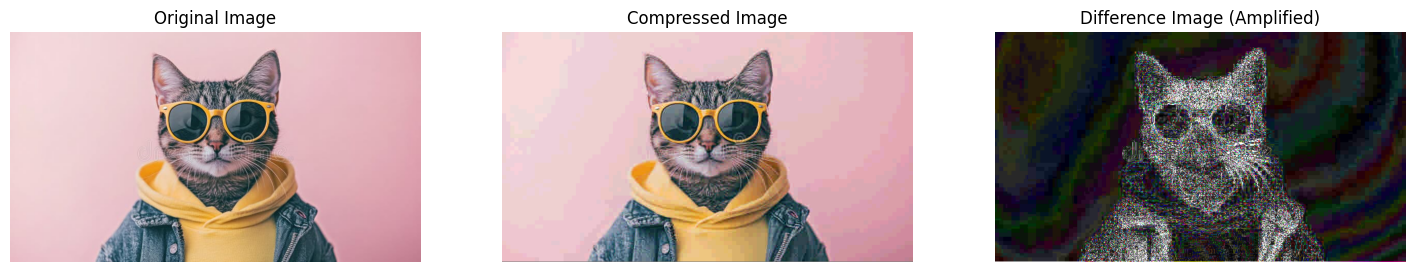

Compression Ratio (CR): 7.16
Mean Squared Error (MSE): 71.48
Peak Signal-to-Noise Ratio (PSNR): 29.59 dB
Rate Distortion (RD): 16852.57


In [8]:
# =========================================
# LAB 10 – IMAGE COMPRESSION (Colab Ready)
# Full JPEG-like DCT + Huffman Coding for Color Images
# =========================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import heapq
import math
from collections import defaultdict
from google.colab import files

# ------------------------------
# UPLOAD IMAGE INTERACTIVELY
# ------------------------------
print("Upload your image file (JPEG/PNG):")
uploaded = files.upload()  # Prompts user to choose a file
image_path = next(iter(uploaded))  # Get uploaded filename
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image is None:
    raise FileNotFoundError(f"Could not read the uploaded file: {image_path}")

image = image.astype(np.float32)

# ------------------------------
# JPEG-LIKE DCT COMPRESSION
# ------------------------------
BLOCK = 8

# Standard JPEG quantization matrix
Q = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=np.float32)

scale_factor = 5  # Increase for more visible compression
Q_scaled = Q * scale_factor

def block_process(img, func):
    h, w = img.shape
    output = np.zeros_like(img)
    for i in range(0, h, BLOCK):
        for j in range(0, w, BLOCK):
            block = img[i:i+BLOCK, j:j+BLOCK]
            if block.shape == (BLOCK, BLOCK):
                output[i:i+BLOCK, j:j+BLOCK] = func(block)
    return output

# Process each channel separately
channels = cv2.split(image)
reconstructed_channels = []
quantized_channels = []

for ch in channels:
    # Center around 0
    dct_ch = block_process(ch - 128, cv2.dct)
    quant_ch = block_process(dct_ch, lambda b: np.round(b / Q_scaled))
    dequant_ch = block_process(quant_ch, lambda b: b * Q_scaled)
    rec_ch = block_process(dequant_ch, cv2.idct) + 128
    rec_ch = np.clip(rec_ch, 0, 255)
    reconstructed_channels.append(rec_ch)
    quantized_channels.append(quant_ch)

reconstructed_color = cv2.merge(reconstructed_channels).astype(np.uint8)

# ------------------------------
# HUFFMAN CODING (per channel)
# ------------------------------
class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = defaultdict(int)
    for x in data.flatten():
        freq[int(x)] += 1
    heap = [HuffmanNode(k, v) for k, v in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        a = heapq.heappop(heap)
        b = heapq.heappop(heap)
        node = HuffmanNode(None, a.freq + b.freq)
        node.left = a
        node.right = b
        heapq.heappush(heap, node)
    return heap[0]

def generate_codes(node, code="", codes=None):
    if codes is None:
        codes = {}
    if node is not None:
        if node.symbol is not None:
            codes[node.symbol] = code
        generate_codes(node.left, code + "0", codes)
        generate_codes(node.right, code + "1", codes)
    return codes

# Encode all channels for demonstration
encoded_bits_per_channel = []
for q_ch in quantized_channels:
    tree = build_huffman_tree(q_ch)
    codes = generate_codes(tree)
    encoded_bits = "".join(codes[int(x)] for x in q_ch.flatten())
    encoded_bits_per_channel.append(encoded_bits)

# ------------------------------
# METRICS (CR, MSE, PSNR, RD)
# ------------------------------
def mse(a, b):
    return np.mean((a - b) ** 2)

def psnr(mse_val):
    if mse_val == 0:
        return float('inf')
    return 20 * math.log10(255 / math.sqrt(mse_val))

# Total original and compressed bits
original_bits = image.size * 8
compressed_bits = sum(len(bits) for bits in encoded_bits_per_channel)

CR = original_bits / compressed_bits
MSE_val = mse(image, reconstructed_color)
PSNR_val = psnr(MSE_val)
RD = compressed_bits / MSE_val

# ------------------------------
# DIFFERENCE IMAGE (AMPLIFIED FOR VISIBILITY)
# ------------------------------
diff_image = cv2.absdiff(image.astype(np.float32), reconstructed_color.astype(np.float32))
diff_image_vis = np.clip(diff_image * 10, 0, 255).astype(np.uint8)  # Amplify differences

# ------------------------------
# DISPLAY RESULTS
# ------------------------------
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(reconstructed_color, cv2.COLOR_BGR2RGB))
plt.title("Compressed Image")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(diff_image_vis, cv2.COLOR_BGR2RGB))
plt.title("Difference Image (Amplified)")
plt.axis('off')

plt.show()

print("Compression Ratio (CR):", round(CR, 2))
print("Mean Squared Error (MSE):", round(MSE_val, 2))
print("Peak Signal-to-Noise Ratio (PSNR):", round(PSNR_val, 2), "dB")
print("Rate Distortion (RD):", round(RD, 2))